In [18]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn as nn
from torch.optim import AdamW
import functions_text_model as functions

First we have to load the datasets, which have already been prepared in `data_labelling_json.ipynb`. The different datasets are:
- mixed_data: all utterances for which the speaker gender has been identified
- F_data: all utterances in which the speaker is a woman
- M_data: all utterances in which the speaker is a man

In [19]:
# Load the data from the JSON files
with open('data/mixed_data.json') as file:
    mixed_data = json.load(file)

with open('data/F_data.json') as file:
    F_data = json.load(file)

with open('data/M_data.json') as file:
    M_data = json.load(file)

with open('data/mixed_data_enriched.json') as file:
    mixed_data_enriched = json.load(file)

with open('data/M_data_enriched.json') as file:
    M_data_enriched = json.load(file)

# Convert the data to lists of dictionaries
mixed_data = list(mixed_data.values())
F_data = list(F_data.values())
M_data = list(M_data.values())
mixed_data_enriched = list(mixed_data_enriched.values())
M_data_enriched = list(M_data_enriched.values())

Let's define some classes and functions needed in the training pipeline.

In [20]:
# Class for the PyTorch sarcasm detection Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        context = item['context']
        utterance_and_context = ' '.join([sentence for sentence in context] + [utterance]) # Combining the utterance and its context into one string.
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance_and_context)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We will now train 3 different models: 
- one model will be trained on all of the videos (video_files)
- one model will be trained on videos from female speakers only (F_videos)
- one model will be trained on videos from male speakers only (M_videos)

train Loss: 0.1836,  ACC: 0.9683, F1-weighted: 0.9678


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


eval Loss: 0.7104,  ACC: 0.6928, F1-weighted: 0.6788


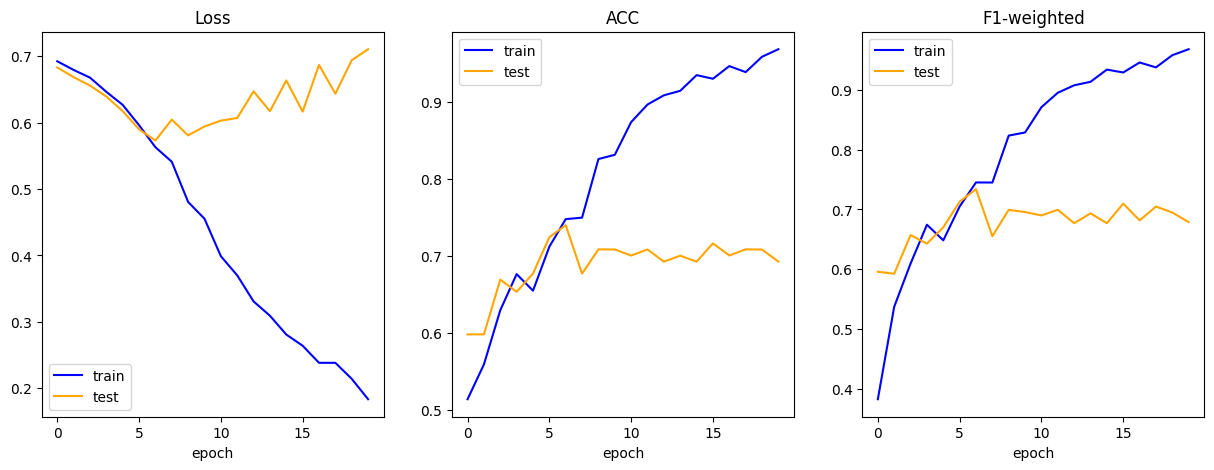

train loss [0.692214697599411, 0.679189071059227, 0.6676107123494148, 0.6462280824780464, 0.6265942379832268, 0.5960225611925125, 0.5628571882843971, 0.5410062596201897, 0.4804334342479706, 0.45521317422389984, 0.39884858578443527, 0.3700013570487499, 0.33077677339315414, 0.3092430904507637, 0.28085828199982643, 0.26409048214554787, 0.23834949731826782, 0.23833869770169258, 0.2142652254551649, 0.1835663802921772] test loss [0.6829186975955963, 0.6683434844017029, 0.6556629538536072, 0.639161229133606, 0.6171588599681854, 0.5897953808307648, 0.5729035437107086, 0.6044062972068787, 0.580652117729187, 0.5941002666950226, 0.6028585731983185, 0.6069333553314209, 0.6468854248523712, 0.6170797049999237, 0.6632834076881409, 0.6164570450782776, 0.6867127120494843, 0.6434137523174286, 0.6938274800777435, 0.7103613317012787]


In [21]:
# MIXED MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(mixed_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
mixed_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

mixed_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

mixed_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(mixed_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(mixed_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(mixed_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
# torch.save(mixed_model.state_dict(), 'models/mixed_model_text.pth')

train Loss: 0.1947,  ACC: 0.9548, F1-weighted: 0.9544


100%|██████████| 2/2 [00:00<00:00, 15.02it/s]


eval Loss: 0.8347,  ACC: 0.6160, F1-weighted: 0.5982


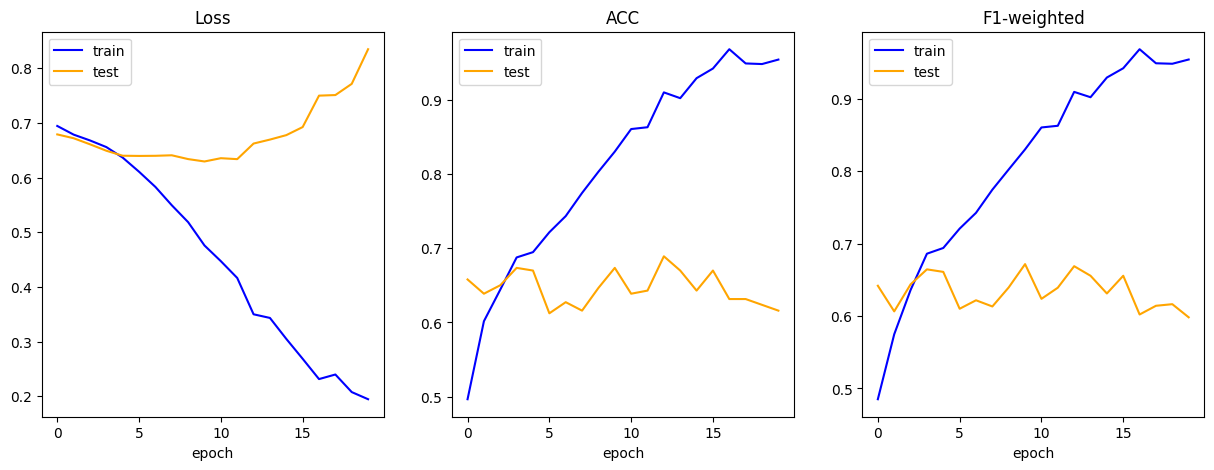

train loss [0.6943811277548472, 0.6785639524459839, 0.6679036219914755, 0.6557743847370148, 0.6364949842294058, 0.610649824142456, 0.5828645726044973, 0.5493872861067454, 0.5184729546308517, 0.47580961883068085, 0.4471183468898137, 0.41645171741644543, 0.349969024459521, 0.3433244079351425, 0.3050022100408872, 0.2686223139365514, 0.23149289190769196, 0.23986203968524933, 0.20773079742987952, 0.19466804713010788] test loss [0.6789345145225525, 0.6719388067722321, 0.6608452498912811, 0.6490586996078491, 0.6399501264095306, 0.6395756900310516, 0.6398122310638428, 0.6407502591609955, 0.6337890028953552, 0.6294383704662323, 0.6354269683361053, 0.6336931586265564, 0.662208616733551, 0.6694625616073608, 0.6775988936424255, 0.6923452019691467, 0.7498154044151306, 0.7508877813816071, 0.7713675498962402, 0.8347053825855255]


In [22]:
# MIXED MODEL ENRICHED

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(mixed_data_enriched)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
mixed_model_enriched = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

mixed_model_enriched.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

mixed_model_enriched.to(device)

# Define optimizer and criterion
optimizer = AdamW(mixed_model_enriched.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(mixed_model_enriched, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(mixed_model_enriched, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
# torch.save(mixed_model_enriched.state_dict(), 'models/mixed_model_enriched_text.pth')

train Loss: 0.3562,  ACC: 0.9433, F1-weighted: 0.9430


100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


eval Loss: 0.4976,  ACC: 0.7561, F1-weighted: 0.7524


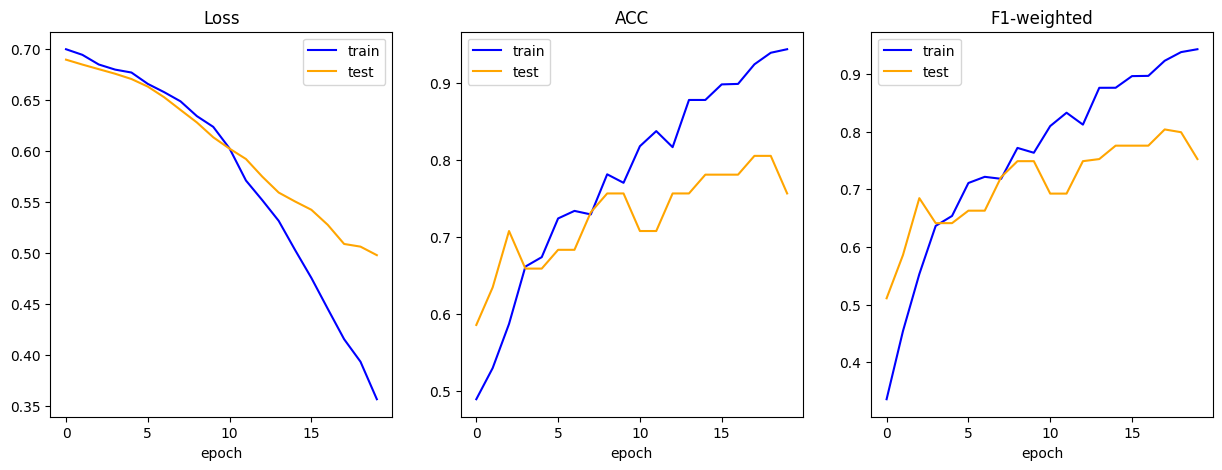

train loss [0.6996711095174154, 0.6941737731297811, 0.6847085555394491, 0.6796796520551046, 0.6768014430999756, 0.6656519969304403, 0.6575312614440918, 0.6485249201456705, 0.6340219179789225, 0.6234872937202454, 0.6022048195203146, 0.5708213249842325, 0.5514964858690897, 0.5312638580799103, 0.5027139683564504, 0.47519756356875104, 0.4449359079202016, 0.4151364167531331, 0.3930649161338806, 0.3562269409497579] test loss [0.6894314885139465, 0.6846226453781128, 0.6801065802574158, 0.6756212115287781, 0.6704311966896057, 0.662999153137207, 0.6525444388389587, 0.6401039361953735, 0.6278095841407776, 0.6132627129554749, 0.6020705699920654, 0.5919404625892639, 0.5746010541915894, 0.5590188503265381, 0.5502740144729614, 0.5421008467674255, 0.527339518070221, 0.508573055267334, 0.5059610605239868, 0.4975843131542206]


In [23]:
# FEMALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(F_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
F_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

F_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

F_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(F_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(F_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(F_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
# torch.save(F_model.state_dict(), 'models/F_model_text.pth')

train Loss: 0.2636,  ACC: 0.9609, F1-weighted: 0.9602


100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


eval Loss: 0.7502,  ACC: 0.6136, F1-weighted: 0.6087


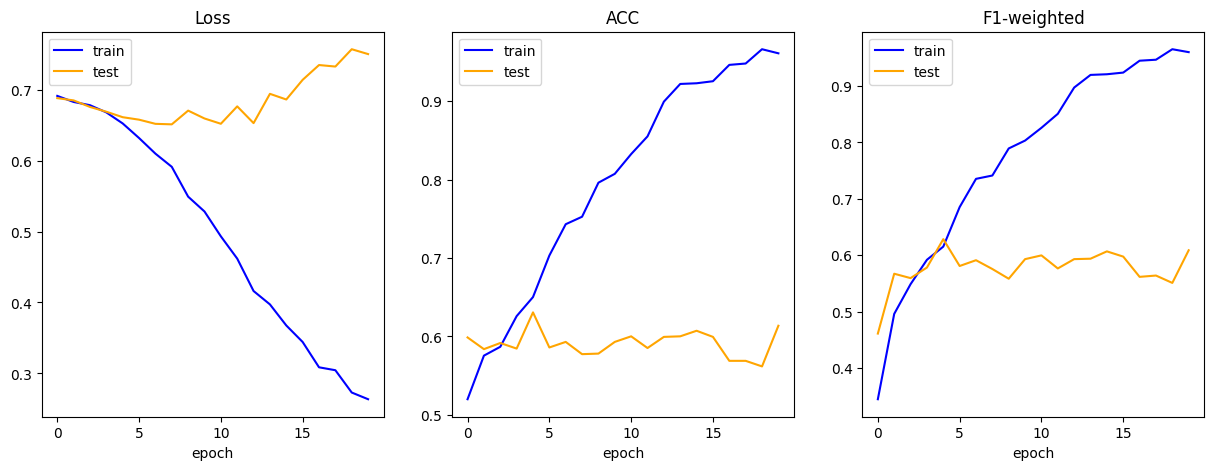

train loss [0.6912254393100739, 0.6826628347237905, 0.6781165798505148, 0.6679348647594452, 0.6523615817228953, 0.6318061848481497, 0.6098042329152426, 0.5912294884522756, 0.5491904318332672, 0.5282406260569891, 0.49323280652364093, 0.46183546384175617, 0.41614145537217456, 0.39728858570257825, 0.36758607625961304, 0.34429504970709485, 0.30861635009447735, 0.3044968495766322, 0.27305885155995685, 0.26362064729134244] test loss [0.6880658864974976, 0.6848563253879547, 0.6756388247013092, 0.6688967049121857, 0.6611821055412292, 0.6576922237873077, 0.651833176612854, 0.6511105000972748, 0.6704638302326202, 0.6593765914440155, 0.6519201695919037, 0.6764408349990845, 0.6528243720531464, 0.6941181421279907, 0.6861500442028046, 0.713860422372818, 0.7347171306610107, 0.7325851321220398, 0.7570117115974426, 0.7501567304134369]


In [24]:
# MALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(M_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
M_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

M_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

M_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(M_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(M_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(M_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
# torch.save(M_model.state_dict(), 'models/M_model_text.pth')

train Loss: 0.1947,  ACC: 0.9548, F1-weighted: 0.9544


100%|██████████| 2/2 [00:00<00:00, 13.65it/s]


eval Loss: 0.8347,  ACC: 0.6160, F1-weighted: 0.5982


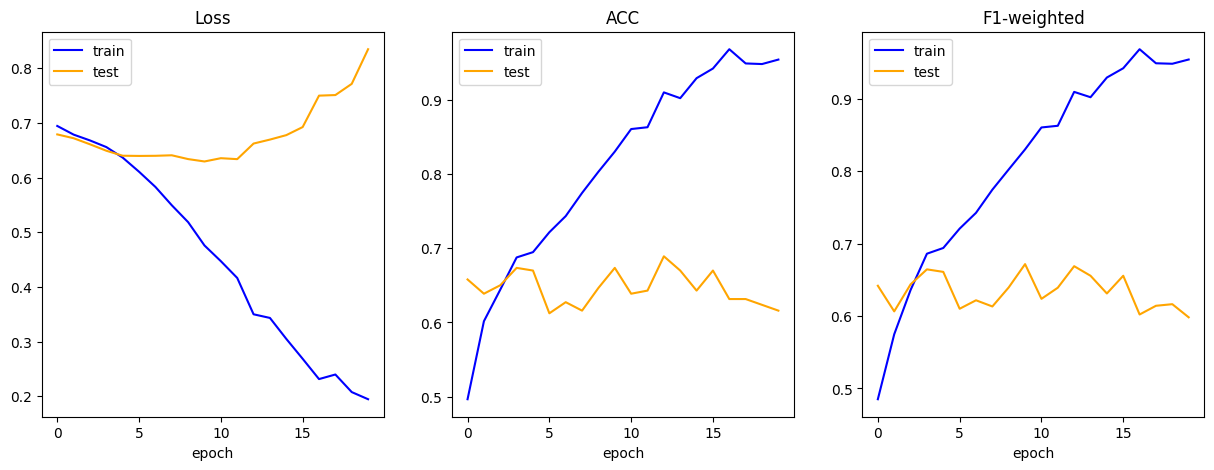

train loss [0.6943811277548472, 0.6785639524459839, 0.6679036219914755, 0.6557743847370148, 0.6364949842294058, 0.610649824142456, 0.5828645726044973, 0.5493872861067454, 0.5184729546308517, 0.47580961883068085, 0.4471183468898137, 0.41645171741644543, 0.349969024459521, 0.3433244079351425, 0.3050022100408872, 0.2686223139365514, 0.23149289190769196, 0.23986203968524933, 0.20773079742987952, 0.19466804713010788] test loss [0.6789345145225525, 0.6719388067722321, 0.6608452498912811, 0.6490586996078491, 0.6399501264095306, 0.6395756900310516, 0.6398122310638428, 0.6407502591609955, 0.6337890028953552, 0.6294383704662323, 0.6354269683361053, 0.6336931586265564, 0.662208616733551, 0.6694625616073608, 0.6775988936424255, 0.6923452019691467, 0.7498154044151306, 0.7508877813816071, 0.7713675498962402, 0.8347053825855255]


In [25]:
# MALE MODEL ENRICHED

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(M_data_enriched)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
M_model_enriched = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

M_model_enriched.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

M_model_enriched.to(device)

# Define optimizer and criterion
optimizer = AdamW(M_model_enriched.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(M_model_enriched, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(M_model_enriched, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
# torch.save(M_model_enriched.state_dict(), 'models/M_model_text.pth')